In [1]:
import os
import sys

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize

import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.nn import CrossEntropyLoss
from torch.optim import SGD, Adam, lr_scheduler
import torchvision
import torchvision.transforms as T

from sys import platform

DEVICE = 'mps' if platform == 'darwin' else 'cuda'

/srv/share/gstoica3/miniconda3/envs/open-mmlab/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import pdb

In [3]:
from collections import defaultdict
import torch.nn.functional as F

In [15]:
from resnets import resnet20

In [4]:
def save_model(model, i):
    sd = model.state_dict()
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        '/srv/share/gstoica3/checkpoints/REPAIR/',
        '%s.pth.tar' % i
    )
    torch.save(model.state_dict(), path)

def load_model(model, i):
    path = os.path.join(
        # '/Users/georgestoica/Downloads',
        '/srv/share/gstoica3/checkpoints/REPAIR/',
        '%s.pth.tar' % i
    )
    sd = torch.load(path, map_location=torch.device(DEVICE))
    model.load_state_dict(sd)

In [5]:
cifar100_info = {
    'dir': '/nethome/gstoica3/research/pytorch-cifar100/data/cifar-100-python',
    'classes1': np.arange(50),
    'classes2': np.arange(50, 100),
    'num_classes': 100,
    'split_classes': 50,
    'wrapper': torchvision.datasets.CIFAR100
}

cifar10_info = {
    'dir': '/tmp',
    'classes1': np.array([3, 2, 0, 6, 4]),
    'classes2': np.array([5, 7, 9, 8, 1]),
    'num_classes': 10,
    'split_classes': 5,
    'wrapper': torchvision.datasets.CIFAR10
}

ds_info = cifar10_info

In [6]:
import random
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

In [7]:
import numpy as np
import torch

from torch.utils.data import DataLoader
from torch.utils.data.sampler import BatchSampler


class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, dataset, n_classes, n_samples):
        loader = DataLoader(dataset)
        self.labels_list = []
        for _, label in loader:
            self.labels_list.append(label)
        self.labels = torch.LongTensor(self.labels_list)
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.dataset = dataset
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size <= len(self.dataset):
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return len(self.dataset) // self.batch_size

In [8]:
CIFAR_MEAN = [125.307, 122.961, 113.8575]
CIFAR_STD = [51.5865, 50.847, 51.255]
normalize = T.Normalize(np.array(CIFAR_MEAN)/255, np.array(CIFAR_STD)/255)
denormalize = T.Normalize(-np.array(CIFAR_MEAN)/np.array(CIFAR_STD), 255/np.array(CIFAR_STD))

train_transform = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomCrop(32, padding=4),
    T.ToTensor(),
    normalize,
])
test_transform = T.Compose([
    T.ToTensor(),
    normalize,
])
train_dset = ds_info['wrapper'](root=ds_info['dir'], train=True,
                                        download=True, transform=train_transform)
test_dset = ds_info['wrapper'](root=ds_info['dir'], train=False,
                                        download=True, transform=test_transform)

train_aug_loader = torch.utils.data.DataLoader(train_dset, batch_size=500, shuffle=True, num_workers=8)
test_loader = torch.utils.data.DataLoader(test_dset, batch_size=500, shuffle=False, num_workers=8)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
model1_classes= ds_info['classes1']#np.array([3, 2, 0, 6, 4])
model2_classes = ds_info['classes2']

valid_examples1 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model1_classes]
valid_examples2 = [i for i, (_, label) in tqdm(enumerate(train_dset)) if label in model2_classes]

assert len(set(valid_examples1).intersection(set(valid_examples2))) == 0, 'sets should be disjoint'

train_aug_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples1), batch_size=500, shuffle=False, num_workers=8
)
train_aug_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(train_dset, valid_examples2), batch_size=500, shuffle=False, num_workers=8
)

test_valid_examples1 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model1_classes]
test_valid_examples2 = [i for i, (_, label) in tqdm(enumerate(test_dset)) if label in model2_classes]

test_loader1 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples1), batch_size=500, shuffle=False, num_workers=8
)
test_loader2 = torch.utils.data.DataLoader(
    torch.utils.data.Subset(test_dset, test_valid_examples2), batch_size=500, shuffle=False, num_workers=8
)

50000it [00:14, 3544.07it/s]
50000it [00:14, 3538.60it/s]
10000it [00:01, 5333.62it/s]
10000it [00:01, 5373.89it/s]


In [10]:
balanced_batched_sampler = BalancedBatchSampler(train_dset, n_classes=ds_info['num_classes'], n_samples=50)
balanced_train_aug_loader = torch.utils.data.DataLoader(
    train_dset, num_workers=8, batch_sampler=balanced_batched_sampler
)

In [11]:
class_idxs = np.zeros(ds_info['num_classes'], dtype=int)
class_idxs[model1_classes] = np.arange(ds_info['split_classes'])
class_idxs[model2_classes] = np.arange(ds_info['split_classes'])
class_idxs = torch.from_numpy(class_idxs)
print(class_idxs)

tensor([2, 4, 1, 0, 4, 0, 3, 1, 3, 2])


In [12]:
# use the train loader with data augmentation as this gives better results
def reset_bn_stats(model, epochs=1, loader=train_aug_loader):
    # resetting stats to baseline first as below is necessary for stability
    for m in model.modules():
        if type(m) == nn.BatchNorm2d:
            m.momentum = None # use simple average
            m.reset_running_stats()
    # run a single train epoch with augmentations to recalc stats
    model.train()
    for _ in range(epochs):
        with torch.no_grad(), autocast():
            for images, _ in loader:
                output = model(images.to(DEVICE))

In [13]:
# evaluates accuracy
def evaluate_texthead(model, loader, class_vectors, remap_class_idxs=None, return_confusion=False):
    model.eval()
    correct = 0
    total = 0
    
    totals = [0] * class_vectors.shape[0]
    corrects = [0] * class_vectors.shape[0]
    
    with torch.no_grad(), autocast():
        for inputs, labels in loader:
            encodings = model(inputs.to(DEVICE))
            normed_encodings = encodings / encodings.norm(dim=-1, keepdim=True)
            outputs = normed_encodings @ class_vectors.T
            pred = outputs.argmax(dim=1)
            if remap_class_idxs is not None:
                correct += (remap_class_idxs[labels].to(DEVICE) == pred).sum().item()
            else:
                for gt, p in zip(labels, pred):
                    totals[gt] += 1
                    
                    if gt == p:
                        correct += 1
                        corrects[gt] += 1
                
            total += inputs.shape[0]
    if return_confusion:
        return correct / sum(totals), list(map(lambda a: a[0] / a[1], zip(corrects, totals)))
    else:
        return correct / total

In [14]:
import clip

text_inputs = torch.cat([clip.tokenize(f"a photo of a {c}") for c in test_dset.classes]).to(DEVICE)
model, preprocess = clip.load('ViT-B/32', DEVICE)
with torch.no_grad():
    text_features = model.encode_text(text_inputs)


text_features /= text_features.norm(dim=-1, keepdim=True)
class_vecs1 = text_features[model1_classes]
class_vecs2 = text_features[model2_classes]

In [199]:
def prune_tensors_by_minimums(
    scores,
    r=.5
):
    O = scores.shape[0]
    total_to_prune = int(O * r)
    permutation_matrix = torch.eye(O, O, device=scores.device)
    search_space = scores.clone()
    min_args = search_space.argsort()[:total_to_prune]
    torch.diagonal(permutation_matrix)[min_args] = 0.
    return permutation_matrix.T, permutation_matrix

def prune_tensors_by_threshold(
    scores,
    threshold=0.
):
    O = scores.shape[0]
    permutation_matrix = torch.eye(O, O, device=scores.device)
    search_space = scores.clone()
    min_args = (search_space <= threshold).to(torch.float).nonzero().view(-1)
    torch.diagonal(permutation_matrix)[min_args] = 0.
    return permutation_matrix.T, permutation_matrix

def remove_col(x, idx):
    return torch.cat([x[:, :idx], x[:, idx+1:]], dim=-1)

def match_tensors_chain_cov(
    covariance,
    r=.5
):
    O = covariance.shape[0]
    remainder = int(O * (1-r))
    bound = O - remainder
    sims = covariance.clone()

    # result after alg should be (O, O-bound)
    permutation_matrix = torch.eye(O, O, device=sims.device)

    for i in range(bound):
        best_idx = sims.reshape(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        
        a = 0.5
        
        permutation_matrix[:, row_idx] += permutation_matrix[:, col_idx]
        permutation_matrix = remove_col(permutation_matrix, col_idx)
        
        sims[:, row_idx] = torch.minimum(a * sims[:, row_idx], a * sims[:, col_idx])
        sims = remove_col(sims, col_idx)
        
        sims[row_idx, :] = torch.minimum(a * sims[row_idx, :], a * sims[col_idx, :])
        sims = remove_col(sims.T, col_idx).T
    
    transformation_matrix = torch.zeros((O, O), device=sims.device)
    transformation_matrix[:, :permutation_matrix.shape[1]] = permutation_matrix
    denom = torch.maximum(transformation_matrix.sum(dim=0, keepdim=True), torch.tensor(1e-5))
    merge = transformation_matrix / denom
    unmerge = transformation_matrix
    return merge.T, unmerge

def match_tensors_pairs_cov(
    covariance,
    r=.5
):
    O = covariance.shape[0]
    remainder = int(O * (1-r))
    bound = O - remainder
    sims = covariance.clone()

    permutation_matrix = torch.eye(O, O, device=sims.device)

    for i in range(bound):
        best_idx = sims.reshape(-1).argmax()
        row_idx = best_idx % sims.shape[1]
        col_idx = best_idx // sims.shape[1]
        
        permutation_matrix[:, row_idx] += permutation_matrix[:, col_idx]
        permutation_matrix = remove_col(permutation_matrix, col_idx)
        
        sims[:, row_idx] = -torch.inf
        sims = remove_col(sims, col_idx)
        sims[row_idx, :] = -torch.inf
        sims = remove_col(sims.T, col_idx).T

    transformation_matrix = torch.zeros((O, O), device=sims.device)
    transformation_matrix[:, :permutation_matrix.shape[1]] = permutation_matrix
    denom = torch.maximum(transformation_matrix.sum(dim=0, keepdim=True), torch.tensor(1e-5))
    merge = transformation_matrix / denom
    unmerge = transformation_matrix
    return merge.T, unmerge

## Single Pass

In [28]:
class ScoringBase(object):
    def __init__(self):
        super(ScoringBase, self).__init__()
        self.layer2score = defaultdict(lambda: None)
        self.output_pattern = lambda model, x: F.relu(model.bn1(model.conv1(x)))
    
    def get_layer_intermediates(self, batch, layer, label, n):
        pass
    
    def get_intermediate_scores(self, model, dataloader, num_passes=1, num_steps=None):
        pass
    
    def batch_update_scores(self, label, out, n):
        pass
    
    def get_layer2score(self):
        return self.layer2score

class CovarianceScoring(ScoringBase):
    def __init__(self):
        super(CovarianceScoring, self).__init__()
        ScoringBase.__init__(self)
    
    def get_layer_intermediates(self, batch, layer, label, n):
        for i, inter in enumerate(list(layer)):
            out = self.output_pattern(inter, batch)
            self.batch_update_scores(label+f'.{i}', out=out, n=n)
            batch = inter(batch)
        self.batch_update_scores(label, out=batch, n=n)
        return batch
    
    def batch_update_scores(self, label, out, n):
        out = out.reshape(out.shape[0], out.shape[1], -1).permute(0, 2, 1)
        out = out.reshape(-1, out.shape[2]).double()
        mean_b = out.mean(dim=0).detach().cpu()
        std_b = out.std(dim=0).detach().cpu()
        outer_b = ((out.T @ out) / out.shape[0]).detach().cpu()

        if self.layer2score[label] is None:
            self.layer2score[label] = {}
            self.layer2score[label]['mean'] = torch.zeros_like(mean_b)
            self.layer2score[label]['std'] = torch.zeros_like(std_b)
            self.layer2score[label]['outer'] = torch.zeros_like(outer_b)
        
        self.layer2score[label]['mean'] += mean_b / n
        self.layer2score[label]['std'] += std_b / n
        self.layer2score[label]['outer'] += outer_b / n

    def get_intermediate_scores(self, model, dataloader, num_passes=1, num_steps=None):
        n = len(dataloader) * num_passes
        with torch.no_grad():
            model.eval()
        
        for _ in range(num_passes):
            for i, (images, _) in enumerate(tqdm(dataloader)):
                if num_steps is not None and i >= num_steps: break
                inputs = images.float().to(DEVICE)
                out = F.relu(model.bn1(model.conv1(inputs)))
                out = self.get_layer_intermediates(out, model.layer1, 'layer1', n)
                out = self.get_layer_intermediates(out, model.layer2, 'layer2', n)
                out = self.get_layer_intermediates(out, model.layer3, 'layer3', n)
        
        for layer, cov in tqdm(self.layer2score.items()):
            mean = cov['mean']
            std = cov['std']
            outer = cov['outer']
            cov = outer - torch.outer(mean, mean)
            cov /= (torch.outer(std, std) + 1e-4)
            torch.diagonal(cov)[:] = -torch.inf
            self.layer2score[layer] = cov
        

class MagnitudeScoring(ScoringBase):
    def __init__(self):
        super(MagnitudeScoring, self).__init__()
        ScoringBase.__init__(self)
    
    def batch_update_scores(self, label, out, n):
        out = out.reshape(out.shape[0], out.shape[1], -1).permute(0, 2, 1)
        out = out.reshape(-1, out.shape[2]).double()
        mean = (out.mean(dim=0) / n).detach().cpu()
        if self.layer2score[label] is None:
            self.layer2score[label] = torch.zeros_like(mean)
        self.layer2score[label] += mean
    
    def get_layer_intermediates(self, batch, layer, label, n):
        for i, inter in enumerate(list(layer)):
            out = self.output_pattern(inter, batch)
            self.batch_update_scores(label+f'.{i}', out=out, n=n)
            batch = inter(batch)
        self.batch_update_scores(label, out=batch, n=n)
        return batch
    
    def get_intermediate_scores(self, model, dataloader, num_passes=1, num_steps=None):
        n = len(dataloader) * num_passes
        with torch.no_grad():
            model.eval()
        
        for _ in range(num_passes):
            for i, (images, _) in enumerate(tqdm(dataloader)):
                if num_steps is not None and i >= num_steps: break
                inputs = images.float().to(DEVICE)
                out = F.relu(model.bn1(model.conv1(inputs)))
                out = self.get_layer_intermediates(out, model.layer1, 'layer1', n)
                out = self.get_layer_intermediates(out, model.layer2, 'layer2', n)
                out = self.get_layer_intermediates(out, model.layer3, 'layer3', n)

In [18]:
class SinglePassResNet20(object):
    def __init__(self, model):
        super(SinglePassResNet20, self).__init__()
        self.model = model
    
    def prepare_model(self, layer2score, score2update_modules, transformer, precomputed_merges=None):
        layer2merges = {}
        for layer, score in layer2score.items():
            if precomputed_merges is None:
                merge, unmerge = transformer(score)
                layer2merges[layer] = (merge.to(score.device), unmerge.to(score.device))
            else:
                layer2merges[layer] = precomputed_merges[layer]
                merge, unmerge = precomputed_merges[layer]
            output_modules = self.get_model_attributes(score2update_modules[layer]['output'])
            input_modules = self.get_model_attributes(score2update_modules[layer]['input'])
            self.transform_output_space(merge, output_modules)
            self.transform_input_space(unmerge, input_modules)
        
        return layer2merges
    
    def get_model_attributes(self, components):
        parameter_tuples = []
        
        for component in components['non_bn']:
            edges = component.split('.')
            node = getattr(self.model, edges[0])
            for edge in edges[1:]:
                node = getattr(node, edge)
            parameter_tuples.append(node.weight)
        
        if 'bn' in components:
            for component in components['bn']:
                edges = component.split('.')
                node = getattr(self.model, edges[0])
                for edge in edges[1:]:
                    node = getattr(node, edge)
                parameter_tuples.append(node.weight)
                parameter_tuples.append(node.bias)
                parameter_tuples.append(node.running_mean)
                parameter_tuples.append(node.running_var)
        return parameter_tuples
    
    def transform_output_space(self, merge, list_of_modules):
        for module in list_of_modules:
            if len(module.shape) == 4:
                transformed_module = torch.einsum('ab,bcde->acde', merge.to(module.device), module)
            else:
                transformed_module = merge.to(module.device) @ module
            module.data = transformed_module

    def transform_input_space(self, unmerge, list_of_modules):
        for module in list_of_modules:
            if len(module.shape) == 4:
                module.data = torch.einsum('abcd,be->aecd', module, unmerge.to(module.device))
            else:
                module.data = (module @ unmerge.to(module.device))

In [19]:
intermediate_layers = [
    'layer1.0',
    'layer1.1',
    'layer1.2',
    'layer2.0',
    'layer2.1',
    'layer2.2',
    'layer3.0',
    'layer3.1',
    'layer3.2'
]

In [20]:
cov2update_modules = {
    'layer1': {
        'output': {
            'non_bn': ['conv1', 'layer1.0.conv2', 'layer1.1.conv2', 'layer1.2.conv2'],
            'bn': ['bn1', 'layer1.0.bn2', 'layer1.1.bn2', 'layer1.2.bn2']
        },
        'input': {
            'non_bn': ['layer1.0.conv1', 'layer1.1.conv1', 'layer1.2.conv1', 
                     'layer2.0.conv1', 'layer2.0.shortcut.0'],
        }
    },
    'layer2': {
        'output': {
            'non_bn': ['layer2.0.conv2', 'layer2.1.conv2', 'layer2.2.conv2', 'layer2.0.shortcut.0'],
            'bn': ['layer2.0.bn2', 'layer2.1.bn2', 'layer2.2.bn2', 'layer2.0.shortcut.1']
        },
        'input': {
            'non_bn': ['layer2.1.conv1', 'layer2.2.conv1', 'layer3.0.conv1', 'layer3.0.shortcut.0']
        }
    },
    'layer3': {
        'output': {
            'non_bn': ['layer3.0.conv2', 'layer3.1.conv2', 'layer3.2.conv2', 'layer3.0.shortcut.0'],
            'bn': ['layer3.0.bn2', 'layer3.1.bn2', 'layer3.2.bn2', 'layer3.0.shortcut.1']
        },
        'input': {
            'non_bn': ['layer3.1.conv1', 'layer3.2.conv1', 'linear']
        }
    },
}

for layer_name in intermediate_layers:
    cov2update_modules[layer_name] = {
        'output': {
            'non_bn': [f'{layer_name}.conv1'],
            'bn': [f'{layer_name}.bn1']
        },
        'input': {
            'non_bn': [f'{layer_name}.conv2']
        }
    }

In [216]:
model0 = resnet20(w=4, text_head=True).to(DEVICE)
load_model(model0, f'resnet20x4_CIFAR5_clses{model1_classes.tolist()}')
print(evaluate_texthead(model0, test_loader1, class_vecs1, remap_class_idxs=class_idxs))

0.9558


In [217]:
# model1 = resnet20(w=4, text_head=True).to(DEVICE)
# load_model(model1, f'resnet20x4_CIFAR5_clses{model2_classes.tolist()}')
# print(evaluate_texthead(model1, test_loader2, class_vecs2, remap_class_idxs=class_idxs))

In [218]:
spr20 = SinglePassResNet20(model=model0)

In [209]:
scorer = CovarianceScoring()

In [210]:
scorer.get_intermediate_scores(
    spr20.model,
    train_aug_loader,
    num_passes=1
)

100%|██████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 124.43it/s]


In [211]:
scorer.get_layer2score().keys()

dict_keys(['layer1.0', 'layer1.1', 'layer1.2', 'layer1', 'layer2.0', 'layer2.1', 'layer2.2', 'layer2', 'layer3.0', 'layer3.1', 'layer3.2', 'layer3'])

In [219]:
r = 1.
threshold = 1e-3
argmin_prune_wrapper = lambda x: prune_tensors_by_minimums(x, r=r)
threshold_prune_wrapper = lambda x: prune_tensors_by_threshold(x, threshold=threshold)
chain_cov_wrapper = lambda x: match_tensors_chain_cov(x, r=r)
pairs_cov_wrapper = lambda x: match_tensors_pairs_cov(x, r=r)


In [220]:
transformer = prune_tensors_by_minimums

In [221]:
layer2merges_ = spr20.prepare_model(
    layer2score=scorer.get_layer2score(), 
    score2update_modules=cov2update_modules, 
    transformer=transformer
)

In [222]:
reset_bn_stats(spr20.model, loader=train_aug_loader)
print(evaluate_texthead(spr20.model, test_loader1, class_vecs1, remap_class_idxs=class_idxs))

0.2


In [177]:
for key, score in scorer.get_layer2score().items():
    merge, unmerge = transformer(score)
    bincounts = torch.bincount(unmerge.sum(dim=0).to(torch.int))
    distribution = {}
    for idx, freq in enumerate(bincounts):
        if idx == 0:
            distribution['Pruned'] = freq.numpy().tolist()
        elif idx == 1:
            distribution['Unmerged'] = freq.numpy().tolist()
        else:
            distribution['Merged'] = freq.numpy().tolist() + distribution.get('Merged', 0)
                
    print(f'{key}: {distribution}')

layer1.0: {'Pruned': 7, 'Unmerged': 50, 'Merged': 7}
layer1.1: {'Pruned': 7, 'Unmerged': 50, 'Merged': 7}
layer1.2: {'Pruned': 7, 'Unmerged': 50, 'Merged': 7}
layer1: {'Pruned': 7, 'Unmerged': 50, 'Merged': 7}
layer2.0: {'Pruned': 13, 'Unmerged': 102, 'Merged': 13}
layer2.1: {'Pruned': 13, 'Unmerged': 102, 'Merged': 13}
layer2.2: {'Pruned': 13, 'Unmerged': 102, 'Merged': 13}
layer2: {'Pruned': 13, 'Unmerged': 102, 'Merged': 13}
layer3.0: {'Pruned': 26, 'Unmerged': 204, 'Merged': 26}
layer3.1: {'Pruned': 26, 'Unmerged': 204, 'Merged': 26}
layer3.2: {'Pruned': 26, 'Unmerged': 204, 'Merged': 26}
layer3: {'Pruned': 26, 'Unmerged': 204, 'Merged': 26}


In [223]:
def get_performance_trend(model_path, codomain, scorer, matcher, test_loader, test_classes):
    model = resnet20(w=4, text_head=True).to(DEVICE)
    load_model(model, model_path)
    scorer.get_intermediate_scores(model, train_aug_loader, num_passes=1)
    perfs = []
    for element in tqdm(codomain):
        wrapper = lambda x: matcher(x, element)
        spr20 = SinglePassResNet20(model=model)
        spr20.prepare_model(
            layer2score=scorer.get_layer2score(), 
            score2update_modules=cov2update_modules, 
            transformer=wrapper
        )
        reset_bn_stats(spr20.model, loader=train_aug_loader)
        perfs += [evaluate_texthead(spr20.model, test_loader, test_classes, remap_class_idxs=class_idxs)]
        load_model(model, model_path)
    return perfs
        

In [182]:
model_path = f'resnet20x4_CIFAR5_clses{model1_classes.tolist()}'
step = .05
codomain = np.arange(0., .5 + step, step)
matcher = match_tensors_pairs_cov

In [183]:
pairs_perfs = get_performance_trend(
    model_path=model_path, 
    codomain=codomain,
    scorer=CovarianceScoring(),
    matcher=matcher, 
    test_loader=test_loader1, 
    test_classes=class_vecs1
)

100%|███████████████████████████████████████████████████████████| 11/11 [01:23<00:00,  7.55s/it]


In [185]:
chain_perfs = get_performance_trend(
    model_path=model_path, 
    codomain=codomain,
    scorer=CovarianceScoring(),
    matcher=match_tensors_chain_cov, 
    test_loader=test_loader1, 
    test_classes=class_vecs1
)

100%|███████████████████████████████████████████████████████████| 11/11 [01:33<00:00,  8.53s/it]


In [224]:
minimum_perfs = get_performance_trend(
    model_path=model_path, 
    codomain=codomain,
    scorer=MagnitudeScoring(),
    matcher=prune_tensors_by_minimums, 
    test_loader=test_loader1, 
    test_classes=class_vecs1
)

100%|███████████████████████████████████████████████████████████| 11/11 [01:16<00:00,  6.98s/it]


In [225]:
print(pairs_perfs)
print(chain_perfs)
print(minimum_perfs)

[0.9462, 0.9436, 0.9398, 0.9332, 0.9292, 0.926, 0.9148, 0.9048, 0.8912, 0.8794, 0.8566]
[0.9464, 0.944, 0.9396, 0.9334, 0.9278, 0.9236, 0.9144, 0.9046, 0.8938, 0.8754, 0.8538]
[0.9462, 0.9448, 0.9368, 0.9316, 0.91, 0.8932, 0.8704, 0.8318, 0.7968, 0.6952, 0.5958]


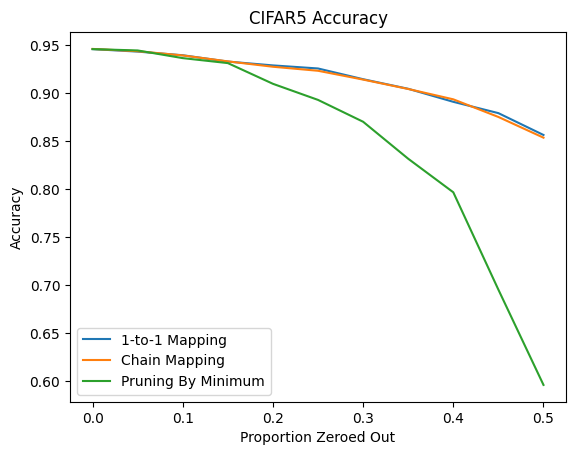

In [230]:
plt.plot(codomain, pairs_perfs, label='1-to-1 Mapping')
plt.plot(codomain, chain_perfs, label='Chain Mapping')
plt.plot(codomain, minimum_perfs, label='Pruning By Minimum')
plt.legend()
plt.xlabel("Proportion Zeroed Out")
plt.ylabel("Accuracy")
plt.title("CIFAR5 Accuracy")
plt.show()